# Imports

In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
sns.set_style("darkgrid")
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
# Allows us to create graph objects for making more customized plots
import plotly.graph_objects as go

# Dates & Other Constants

In [2]:
PATH = "./Stocks/"

# Start date defaults
S_YEAR = 2017
S_MONTH = 1
S_DAY = 3
S_DATE_STR = "2017-01-03"
S_DATE_DATETIME = dt.datetime(S_YEAR, S_MONTH, S_DAY)

# End date defaults
E_YEAR = 2021
E_MONTH = 8
E_DAY = 19
E_DATE_STR = "2021-10-29"
E_DATE_DATETIME = dt.datetime(E_YEAR, E_MONTH, E_DAY)

risk_free_rate = 0.0125 # Approximate 10 year bond rate

# Get Stock File Names in a List

In [3]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
len(tickers) # Total 3029 Stocks

3029

# Function that Returns a Dataframe from a CSV

In [4]:
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + '.csv',
                         index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

# Merge Multiple Stocks in One Dataframe by Column Name

In [5]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv(x)
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

#  Markowitz Portfolio Optimization

Harry Markowitz proved that you could make what is called an efficient portfolio. That is a portfolio that optimizes return while also minimizing risk. We don't benefit from analyzing individual securities at the same rate as if we instead considered a portfolio of stocks.

We do this by creating portfolios with stocks that are not correlated. We want to calculate expected returns by analyzing the returns of each stock multiplied by its weight.

$w_1r_1 + w_2r_2 = r_p$

The standard deviation of the portfolio is found this way. Sum multiple calculations starting by finding the product of the first securities weight squared times its standard deviation squared. The middle is 2 times the correlation coefficient between the stocks. And, finally add those to the weight squared times the standard deviation squared for the second security.

<img src="https://render.githubusercontent.com/render/math?math=%28w_1%5Csigma_1%20%2B%20w_2%5Csigma_2%29%5E2%20%3D%20w_1%5E2%5Csigma_1%5E2%20%2B%202w_1%5Csigma_1w_2%5Csigma_2%5Crho_1%20%2B%20w_2%5E2%5Csigma_2%5E2&mode=inline"/>

# Plotting an Efficient Frontier

# Stock Portfolio

In [6]:
# I used the calculations made in part 4 of this course to pick the best performing
# stocks in the main sectors in the year 2018 through 2019
port_list = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR",
             "MKC", "PG", "PGR", "NEM", "CCI", "COG"]

# Merge all Stock Price Data

In [7]:
mult_df = merge_df_by_column_name('Adj Close',
                                  '2018-01-01', 
                                  '2021-10-01',
                                  *port_list)
mult_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,COG
Date,,,,,,,,,,,,
2018-01-02,48.029999,43.599998,88.318527,10.980000,80.440002,348.970001,47.764656,81.077133,47.696735,34.370628,95.973358,26.367413
2018-01-03,49.730000,43.389999,88.410500,11.550000,81.029999,353.029999,47.877892,80.978737,47.670883,34.082401,95.568062,26.486021
2018-01-04,50.070000,43.740002,88.929497,12.120000,83.110001,349.790009,48.179863,81.551163,47.662270,34.460686,94.457939,26.376534
2018-01-05,50.410000,43.529999,89.737526,11.880000,83.879997,350.880005,48.651711,81.604813,47.843204,34.586788,95.180420,26.239677
2018-01-08,49.529999,43.549999,90.630966,12.280000,84.639999,356.549988,48.703617,82.034134,47.989670,34.550766,95.462341,26.376534
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-27,443.799988,146.710007,298.529999,108.160004,507.019989,734.409973,83.993431,140.787430,90.580635,53.900002,177.250000,21.545780
2021-09-28,425.339996,141.139999,293.510010,101.519997,488.410004,727.489990,82.908035,139.724014,90.250992,54.580002,175.059998,21.311375
2021-09-29,406.529999,141.419998,293.170013,100.349998,495.000000,733.179993,83.336220,141.145218,91.040131,53.709999,175.770004,22.024359


# Plot Growth of Investments over Total Dataset

In [8]:
growth_df = (mult_df / mult_df.iloc[0] * 100)

fig = go.Figure()

for x in growth_df.columns:
    fig.add_trace(go.Scatter(x=growth_df.index, y=growth_df[x], mode="lines", name=x))

fig.update_layout(title="Stock Price Growth",
                  xaxis_title="Date",
                  yaxis_title="Price",
                  height=600,
                  width=1200)

fig.show()

# Mean Returns

In [9]:
returns = np.log(mult_df / mult_df.shift(1))
mean_ret = returns.mean() * 253 # 253 average trading days per year
mean_ret

GNRC    0.571377
CPRT    0.312521
ODFL    0.314480
AMD     0.598543
PAYC    0.492668
CHTR    0.200756
MKC     0.139456
PG      0.143936
PGR     0.172662
NEM     0.118889
CCI     0.157947
COG    -0.051826
dtype: float64

# Covarience

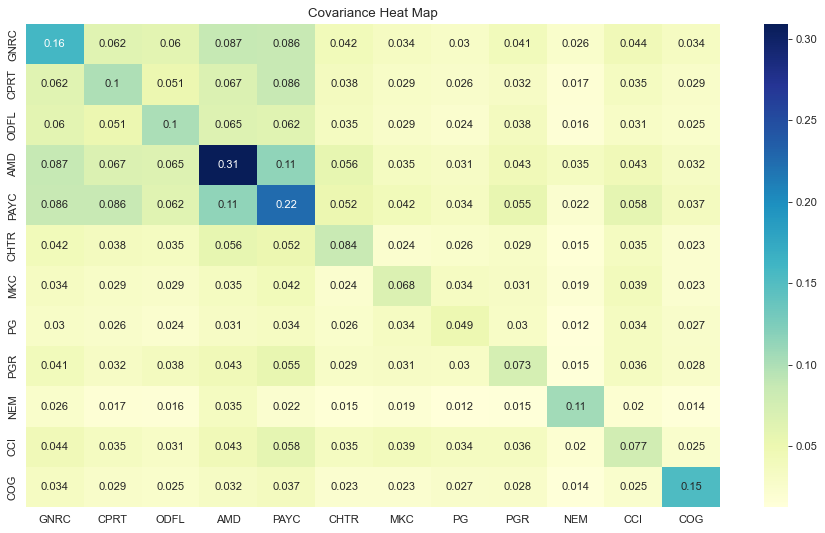

In [10]:
plt.figure(figsize=(14, 8), dpi=80)
sns.heatmap(returns.cov() * 253, annot=True, cmap="YlGnBu")
plt.title("Covariance Heat Map")
plt.show()

# Correlation

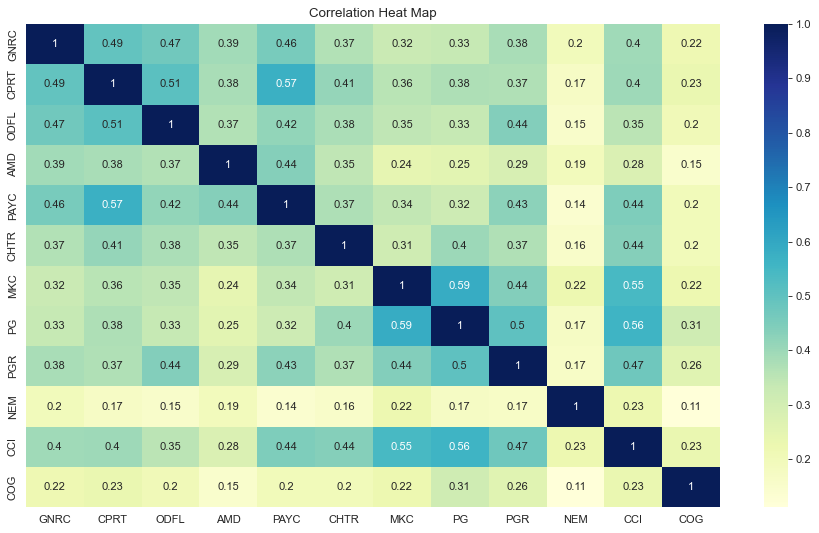

In [11]:
plt.figure(figsize=(14, 8), dpi=80)
sns.heatmap(returns.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Heat Map")
plt.show()

# Generate Random Weights Equal to 1

In [12]:
# Generate 12 random values that sum to 1
weights = np.random.random(12)
weights /= np.sum(weights)
print('Weights :', weights)
print('Total Weight :', np.sum(weights))

Weights : [0.00489059 0.10705208 0.1113479  0.05146304 0.14340511 0.05072004
 0.11837321 0.12083634 0.09903426 0.1213445  0.07064048 0.00089245]
Total Weight : 1.0


# Calculating Return of Portfolio

In [13]:
# Provide return of portfolio using random weights over the whole dataset
np.sum(weights * returns.mean()) * 253

0.2594410310654337

# Calculating Volatility

In [14]:
np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 253, weights)))

0.2126472766066521

In [15]:
p_weights = np.random.random(12)
p_weights /= np.sum(p_weights)
p_weights

array([0.01886673, 0.17132893, 0.08595632, 0.03829869, 0.07456701,
       0.05846951, 0.07770363, 0.07970661, 0.07123106, 0.11684634,
       0.12228255, 0.08474262])

# Analyzing Returns & Risks of 10000 Combinations

In [16]:
p_ret = [] # Returns list
p_vol = [] # Volatility list
p_SR = [] # Sharpe Ratio list
p_wt = [] # Stock weights list

for x in range(10000):
    # Generate random weights
    p_weights = np.random.random(12)
    p_weights /= np.sum(p_weights)
    
    # Add return using those weights to list
    ret_1 = np.sum(p_weights * returns.mean()) * 253
    p_ret.append(ret_1)
    
    # Add volatility or standard deviation to list
    vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * 253, p_weights)))
    p_vol.append(vol_1)
    
    # Get Sharpe ratio
    SR_1 = (ret_1 - risk_free_rate) / vol_1
    p_SR.append(SR_1)
    
    # Store the weights for each portfolio
    p_wt.append(p_weights)
    
# Convert to Numpy arrays
p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt

(array([0.24876885, 0.30460379, 0.22090637, ..., 0.23580171, 0.27154098,
        0.27654348]),
 array([0.21137724, 0.24917562, 0.2140485 , ..., 0.20707982, 0.21215227,
        0.21963523]),
 array([1.11775917, 1.17228077, 0.97364088, ..., 1.07833638, 1.22101444,
        1.20219089]),
 array([[0.05229482, 0.14108187, 0.02521963, ..., 0.12461953, 0.12458991,
         0.07741597],
        [0.11744447, 0.06664927, 0.04022312, ..., 0.04031198, 0.16526788,
         0.15487658],
        [0.04346987, 0.16532913, 0.11464923, ..., 0.00811379, 0.1665873 ,
         0.16096352],
        ...,
        [0.00577441, 0.0609295 , 0.09339036, ..., 0.13137801, 0.14696847,
         0.04558302],
        [0.1595638 , 0.12951729, 0.14980481, ..., 0.03810297, 0.03178224,
         0.07970364],
        [0.13827028, 0.00202275, 0.09015452, ..., 0.11067968, 0.09332119,
         0.11836136]]))

# Plotting the Efficient Frontier

In [17]:
# Create a dataframe with returns and volatility
ports = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})

fig = go.Figure()
fig.add_trace(go.Scatter(
    x = ports.Volatility,
    y = ports.Return,
    mode = "markers",
))
fig.update_layout(title="Volatility vs Return Scatter Plot",
                  xaxis_title="Volatility",
                  yaxis_title="Return",
                  height=600,
                  width=1000)
fig.show()

# Sharpe Ratio

People want to maximize returns while avoiding as much risk as possible. William Sharpe created the Sharpe Ratio to find the portfolio that provides the best return for the lowest amount of risk.

Sharpe Ratio = $\frac{r_i - r_f}{\sigma_i}$

$r_f = $ Risk Free Rate

$r_i = $ Rate of Return of the stock

$\sigma_i = $ Standard Deviation of the Stock

As return increases so does the Sharpe Ratio, but as Standard Deviation increase the Sharpe Ration decreases.

In [18]:
# Return the index of the largest Sharpe Ratio
SR_idx = np.argmax(p_SR)

port_wts = []

# Find the ideal portfolio weighting at that index
i = 0
while i < 12:
    print("Stock : %s : %2.2f" % (port_list[i], (p_wt[SR_idx][i] * 100)))
    port_wts.append(round(p_wt[SR_idx][i] * 100))
    i += 1
    
# Find volatility of that portfolio
print("\nVolatility :", p_vol[SR_idx])
      
# Find return of that portfolio
print("Return :", p_ret[SR_idx])

Stock : GNRC : 23.31
Stock : CPRT : 10.88
Stock : ODFL : 6.47
Stock : AMD : 15.99
Stock : PAYC : 16.66
Stock : CHTR : 3.31
Stock : MKC : 7.52
Stock : PG : 0.96
Stock : PGR : 3.12
Stock : NEM : 8.35
Stock : CCI : 0.81
Stock : COG : 2.64

Volatility : 0.2707827845458461
Return : 0.3989995667700505


# Find the Number of Stocks to Buy for Each Stock

In [19]:
def get_port_shares(one_price, force_one, wts, prices):
    # Gets number of stocks to analyze
    num_stocks = len(wts)
    
    # Holds the number of shares for each
    shares = []
    
    # Holds Cost of shares for each
    cost_shares = []
    
    i = 0
    while i < num_stocks:
        # Get max amount to spend on stock 
        max_price = one_price * wts[i]
        
        # Gets number of shares to buy and adds them to list
        num_shares = int(max_price / prices[i])
        
        # If the user wants to force buying one share do it
        if(force_one & (num_shares == 0)):
            num_shares = 1
        
        shares.append(num_shares)
        
        # Gets cost of those shares and appends to list
        cost = num_shares * prices[i]
        cost_shares.append(cost)
        i += 1
        
    return shares, cost_shares

# Get Portfolio Weighting

In [20]:
def get_port_weighting(share_cost):
    
    # Holds weights for stocks
    stock_wts = []
    # All values summed
    tot_val = sum(share_cost)
    print("Total Investment :", tot_val)
    
    for x in share_cost:
        stock_wts.append(x / tot_val)
    return stock_wts

# Returns the Value of Portfolio by Date

In [21]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_df_start.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    return port_prices

# Approximate Portfolio Weighting Based on Request

In [22]:
port_list = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", 
             "PG", "PGR", "NEM", "CCI", "COG"]

# Get all stock prices on the starting date
port_df_start = merge_df_by_column_name('Adj Close',
                                        '2020-01-02',
                                        '2020-01-02',
                                        *port_list)

# Convert from dataframe to Python list
port_prices = port_df_start.values.tolist()

# Trick that converts a list of lists into a single list
port_prices = sum(port_prices, [])

tot_shares, share_cost = get_port_shares(round(port_prices[0], 2), True, port_wts, port_prices)
print("Shares :", tot_shares, "\n")
print("Share Cost :", share_cost, "\n")

# Get list of weights for stocks
stock_wts = get_port_weighting(share_cost)
print("\n", "Stock Weights :", stock_wts, "\n")

Shares : [22, 12, 4, 33, 6, 1, 10, 1, 4, 19, 1, 18] 

Share Cost : [2244.2200469970708, 1121.7600402832031, 509.4324035644531, 1620.2999496459959, 1630.7999267578125, 490.4299926757813, 815.8400726318359, 117.4814453125, 272.8203125, 785.6105422973633, 134.35507202148438, 290.6410102844238] 

Total Investment : 10033.690814971924

 Stock Weights : [0.22366844747182402, 0.11179934293065438, 0.05077218472830514, 0.16148593568662098, 0.16253240774814284, 0.048878324209868894, 0.08131006702084818, 0.011708696976908864, 0.02719042449393667, 0.07829726436508315, 0.013390393873907737, 0.02896651049389916] 



# Extra

In [23]:
# New Stock Price for Each Stock
old_port_df_start = merge_df_by_column_name('Adj Close',
                                        '2020-01-02',
                                        '2020-01-02',
                                        *port_list)
old_stock_price = old_port_df_start.values.tolist()[0]

# New Stock Price for Each Stock
new_port_df_start = merge_df_by_column_name('Adj Close',
                                        '2020-12-31',
                                        '2020-12-31',
                                        *port_list)
new_stock_price = new_port_df_start.values.tolist()[0] 

# New Value of Shares
new_tot_share_price = []
for i in range(12):
    new_tot_share_price.append(new_stock_price[i] * tot_shares[i])

In [24]:
new_df = pd.DataFrame({
    "Stock Name": port_list,
    "Buying Stock Price": old_stock_price,
    "No Of Stock Bought": tot_shares,
    "Total Money Invested": share_cost,
    "New Stock Price": new_stock_price,
    "Investment Value": new_tot_share_price,
})
new_df

,Stock Name,Buying Stock Price,No Of Stock Bought,Total Money Invested,New Stock Price,Investment Value
0,GNRC,102.010002,22,2244.220047,227.410004,5003.020081
1,CPRT,93.480003,12,1121.760040,127.250000,1527.000000
2,ODFL,127.358101,4,509.432404,194.856201,779.424805
3,AMD,49.099998,33,1620.299950,91.709999,3026.429970
4,PAYC,271.799988,6,1630.799927,452.250000,2713.500000
5,CHTR,490.429993,1,490.429993,661.549988,661.549988
6,MKC,81.584007,10,815.840073,94.464523,944.645233
7,PG,117.481445,1,117.481445,135.726593,135.726593
8,PGR,68.205078,4,272.820312,93.980080,375.920319
9,NEM,41.347923,19,785.610542,58.313404,1107.954678


In [25]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=new_df["Stock Name"],
    y=new_df["Buying Stock Price"],
    name="Buying Stock Price",
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=new_df["Stock Name"],
    y=new_df["New Stock Price"],
    name="New Stock Price",
    marker_color='#49e659'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group',
                  title="Stock Price While Buying vs Stock Price at The End Of 2020",
                  xaxis_title="Stock Ticker",
                  yaxis_title="Stock Price (USD)",
                  height=500,
                  width=1200)
fig.show()

In [26]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=new_df["Stock Name"],
    y=new_df["Total Money Invested"],
    name="Total Money Invested",
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=new_df["Stock Name"],
    y=new_df["Investment Value"],
    name="Investment Value",
    marker_color='#49e659'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group',
                  title="Money Invested vs Value of Stocks at The End of 2020",
                  xaxis_title="Stock Ticker",
                  yaxis_title="Stock Price (USD)",
                  height=500,
                  width=1200)
fig.show()